
## Introduction

In this analysis, we will be calculating the young stars who have the best potential. We will use current data to define the age of a young player, their efficiency based on others, and other criteria. Our goal is to identify the players with the highest potential and analyze their performance in various aspects.

Let's get started!


Source:   
This work was highly inspired by this work: https://www.kaggle.com/code/vivovinco/nba-rising-stars-2022-2023

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
def create_nba_features(players: pd.DataFrame) -> pd.DataFrame:
    """Create features from raw data."""
    players["EFF"] = (
        players.PTS
        + players.TRB
        + players.AST
        + players.STL
        + players.BLK
        - (players.FGA - players.FG)
        - (players.FTA - players.FT)
        - players.TOV
    )

    players['TS%'] = np.where(
        (2 * (players['FGA'] + 0.44 * players['FTA'])) != 0,
        players['PTS'] / (2 * (players['FGA'] + 0.44 * players['FTA'])),
        0
    )

    players["position"] = players.Pos.map(
        {"PG": "Backcourt", "SG": "Backcourt", "SF": "Wing", "SF-PF": "Wing", "PF": "Big", "C": "Big", }
    )

    return players


def stars_definition(row: pd.Series, EFFICENCY_THRESHOLD: int = 12, POINTS_THRESHOLD: int = 10, AGE_THRESHOLD: int = 23) -> bool:
    """Define rising stars."""
    return (
        row["EFF"] >= EFFICENCY_THRESHOLD
        and row["PTS"] >= POINTS_THRESHOLD
        and row["Age"] <= AGE_THRESHOLD
    )

In [3]:
RAW_DATA_DIR = Path('..') / "data" / "raw"
CURATED_DATA_DIR = Path('..') / "data" / "curated"

In [4]:
files = list(RAW_DATA_DIR.glob('*.csv'))
pattern = re.compile(r'\d{4}-\d{4} NBA Player Stats - Regular\.csv$')
matching_files = sorted(f for f in files if pattern.match(f.name))
filename = matching_files[-1]
print(f"Running on file: {filename}")
players = pd.read_csv(filename, encoding='Windows-1252')
players = create_nba_features(players=players)
players["rising_stars"] = players.apply(stars_definition, axis=1)

Running on file: ../data/raw/2023-2024 NBA Player Stats - Regular.csv


In [5]:
name = filename.stem
season = re.search(r"\d{4}-\d{4}", name).group(0)

In [6]:
if not (CURATED_DATA_DIR / (season + "_players.csv")).exists():
    players.to_csv(str(CURATED_DATA_DIR / (season + "_players.csv")), encoding='Windows-1252')
    print("Saved file to: " + str(CURATED_DATA_DIR / (season + "_players.csv")))
else:
    print("File already exists")

Saved file to: ../data/curated/2023-2024_players.csv


In [7]:
players.sort_values(by=['Player'], ascending=True)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,EFF,TS%,position,rising_stars
176,165,A.J. Green,SG,24,MIL,23,0,7.2,1.1,2.3,...,0.6,0.0,0.0,0.0,0.8,3.1,3.2,0.673913,Backcourt,False
272,261,A.J. Lawson,SG,23,DAL,16,0,10.3,1.8,3.7,...,0.6,0.6,0.1,0.5,0.8,4.8,4.8,0.585938,Backcourt,False
182,171,AJ Griffin,SF,20,ATL,13,0,9.0,0.8,2.8,...,0.3,0.1,0.0,0.5,0.5,2.5,1.3,0.432825,Wing,False
172,161,Aaron Gordon,PF,28,DEN,33,33,31.5,5.5,10.2,...,3.2,0.9,0.6,1.3,1.7,13.8,17.9,0.592173,Big,False
210,199,Aaron Holiday,PG,27,HOU,34,1,18.0,2.5,5.7,...,1.7,0.5,0.1,0.8,1.6,6.9,7.1,0.574234,Backcourt,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,96,Zach Collins,C,26,SAS,31,23,26.1,4.9,10.0,...,3.3,0.6,0.8,2.3,3.4,12.9,15.7,0.581081,Big,False
271,260,Zach LaVine,SG,28,CHI,21,19,35.3,7.0,15.8,...,3.7,1.0,0.3,2.1,2.1,20.3,19.0,0.570866,Backcourt,False
358,343,Zeke Nnaji,PF,23,DEN,33,0,9.9,1.2,2.5,...,0.5,0.2,0.6,0.6,1.6,3.3,4.5,0.544914,Big,False
534,511,Ziaire Williams,SF,22,MEM,35,8,18.9,2.8,6.9,...,1.3,0.5,0.3,1.2,1.7,7.8,7.9,0.525040,Wing,False


In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [9]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(),
         ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB',
          'AST', 'STL', 'BLK', 'TOV', 'PF']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Pos', 'Tm'])
    ])

# Define model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [10]:
# Split data into training and test sets
X = players.drop(['Player', 'rising_stars'], axis=1)
y = players['rising_stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'G', 'GS', 'MP', 'FG',
                                                   'FGA', '3P', '3PA', '2P',
                                                   '2PA', 'FT', 'FTA', 'ORB',
                                                   'DRB', 'TRB', 'AST', 'STL',
                                                   'BLK', 'TOV', 'PF']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pos', 'Tm'])])),
                ('classifier', RandomForestClassifier())])

In [12]:
# Make predictions
y_pred = model.predict(X_test)

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.9927007299270073


In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[130,   0],
       [  1,   6]])

Cross-validation scores: [0.97272727 0.97247706 0.94495413 0.93577982 0.98165138]
Mean cross-validation score: 0.9615179316096748


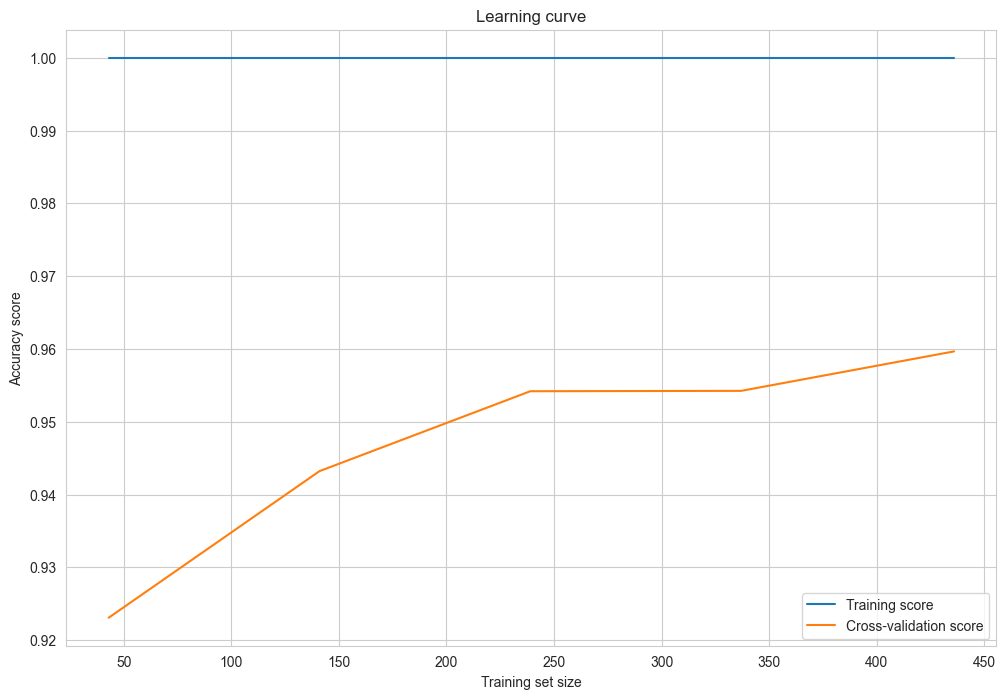

In [15]:
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Learning curves
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning curve')
plt.xlabel('Training set size'), plt.ylabel('Accuracy score'), plt.legend(loc='best')
plt.show()

In [6]:
assert sum(players.isnull().sum()) == 0, "There are not null values in the dataset"

In [7]:
players["EFF"] = players.PTS + players.TRB + players.AST + players.STL + players.BLK - (players.FGA - players.FG) - (players.FTA - players.FT) - players.TOV

<Axes: xlabel='Pos', ylabel='EFF'>

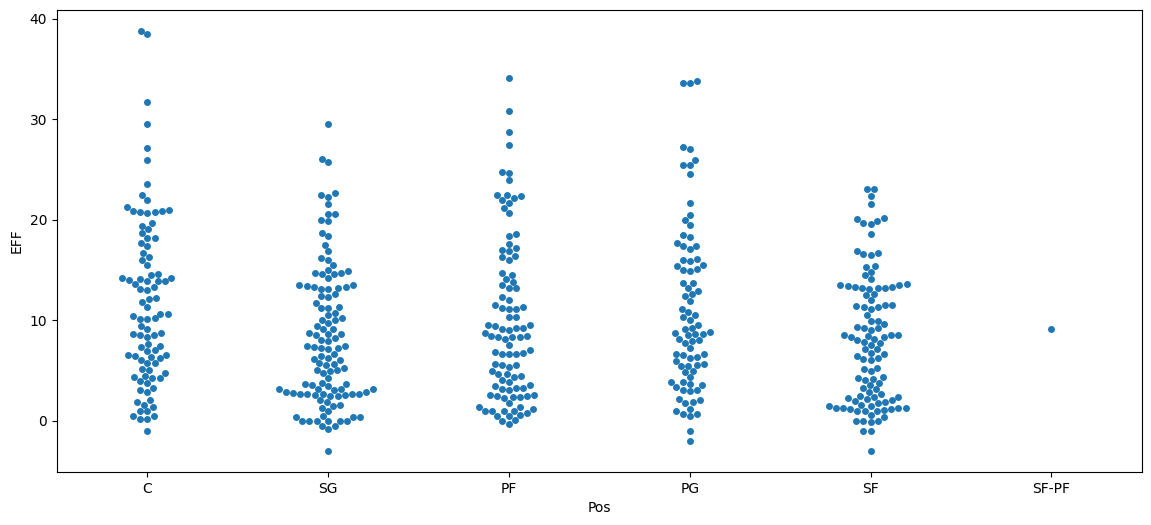

In [8]:
plt.figure(figsize=(14,6))
sns.swarmplot(
    x=players["Pos"],
    y=players["EFF"]
)

In [9]:
ages = players.Age.describe().round(decimals=1) # used to specify the first 25%, defining what is a young player
points = players.PTS.describe().round(decimals=1)

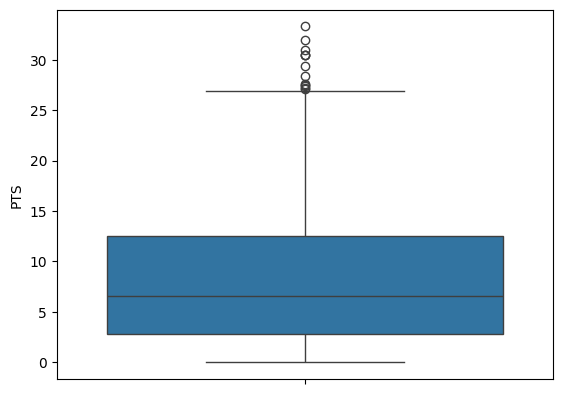

In [10]:
sns.boxplot(data=players, y="PTS");

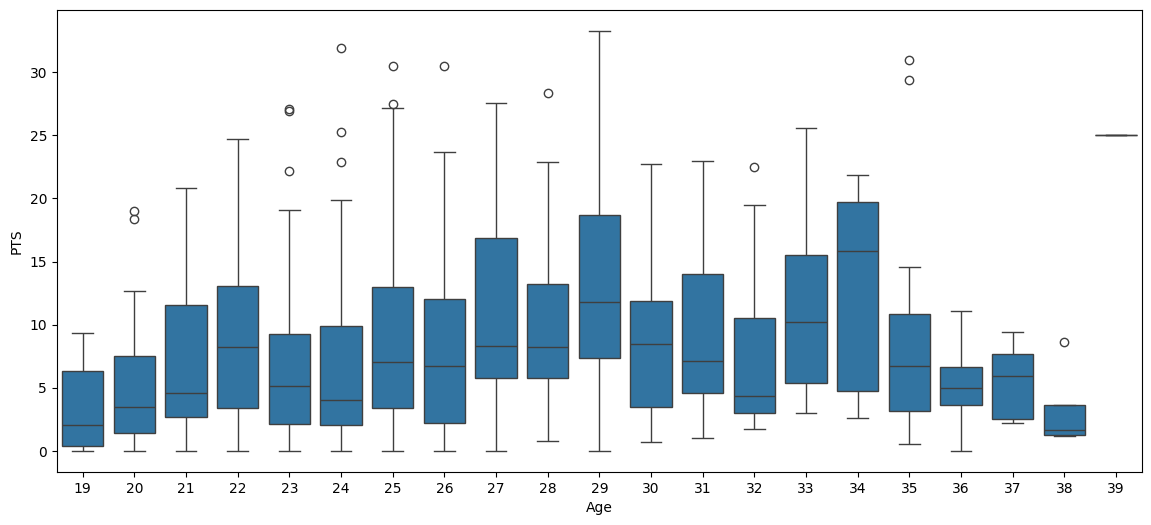

In [11]:
plt.figure(figsize=(14,6))
sns.boxplot(data=players, x="Age", y="PTS");

With the graph below, we can see that within <23y (what we have defined to be a young age), if we have more than 15 points we are special. Those data will then be used to filter the current base player and keep only special ones.

In [12]:
young_age = ages["25%"]
futur_super_star_def = f"(EFF >= 12) & (PTS >= 15) & (Age <= {young_age})"
players.query(futur_super_star_def).sort_values("EFF", ascending=False).sort_values(["Age", "EFF"], ascending=True)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,EFF
407,400,Shaedon Sharpe,SG,20,POR,21,20,37.0,6.4,15.0,...,1.5,4.3,5.8,3.5,1.0,0.4,2.9,3.0,18.4,16.9
476,465,Victor Wembanyama,PF,20,SAS,20,20,30.3,7.1,16.4,...,2.4,7.8,10.2,2.6,1.3,2.7,3.3,2.5,19.0,22.4
162,159,Jalen Green,SG,21,HOU,19,19,31.7,6.4,15.1,...,0.4,4.3,4.6,3.1,0.5,0.4,2.4,1.5,19.1,15.5
22,23,Paolo Banchero,PF,21,ORL,22,22,33.5,7.5,15.3,...,1.3,5.4,6.7,4.5,1.0,0.6,3.0,2.4,20.7,20.7
197,194,Chet Holmgren,C,21,OKC,21,21,30.0,6.0,11.7,...,1.7,6.1,7.8,2.5,0.9,2.4,2.0,2.9,17.1,22.5
402,395,Alperen Þengün,C,21,HOU,19,19,32.9,8.5,15.7,...,2.5,6.5,9.1,5.7,0.9,0.8,2.5,3.2,20.8,25.9
437,428,Cam Thomas,SG,22,BRK,12,10,31.5,8.9,19.8,...,0.2,3.3,3.5,2.3,0.7,0.6,1.7,2.0,23.7,17.5
102,99,Cade Cunningham,PG,22,DET,22,22,34.9,8.1,19.4,...,0.5,3.3,3.8,7.3,1.0,0.2,4.3,2.7,22.0,18.3
486,475,Jalen Williams,PF,22,OKC,18,18,33.1,6.7,13.0,...,0.3,3.9,4.2,3.7,0.9,0.3,1.8,3.0,17.9,18.4
463,452,Franz Wagner,SF,22,ORL,22,22,33.1,7.6,16.5,...,1.2,4.4,5.6,3.7,1.1,0.4,1.7,2.0,20.7,20.2
